In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima,ndiffs,nsdiffs
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error
register_matplotlib_converters()

ARIMA Links :
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- http://alkaline-ml.com/pmdarima/1.5.1/modules/classes.html
- https://alkaline-ml.com/pmdarima/tips_and_tricks.html
- https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
- https://people.duke.edu/~rnau/411diff.htm


Holt Linear Trend Model Links :
- https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
- https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html#statsmodels.tsa.holtwinters.Holt
- https://otexts.com/fpp2/holt.html

conda remove --force pmdarima 
conda install -c conda-forge pmdarima=1.7.1 
conda install -c anaconda statsmodels=0.12.0

# Loading the Data

In [72]:
df_services_male = pd.read_excel("Employment_services_male.xls")
df_services_female = pd.read_excel("Employment_services_female.xls")
df_agriculture_male = pd.read_excel("Employment_agriculture_male.xls")
df_agriculture_female = pd.read_excel("Employment_agriculture_female.xls")
df_industry_male = pd.read_excel("Employment_indusrty_male.xls")
df_industry_female = pd.read_excel("Employment_indusrty_female.xls")
df_economy_types = pd.read_excel("economy_types.xlsx")
df_employment_female = pd.read_excel("EmploymentToPopulationRatio_15+_female.xls")
df_employment_male = pd.read_excel("EmploymentToPopulationRatio_15+_male.xls")

# GEPI Calculation

In [73]:
dict_GenderEmploymentIndex = {'Country Name' : df_economy_types['TableName'],
                              'Country Code' : df_economy_types['Country Code'],
                              'IncomeGroup' : df_economy_types['IncomeGroup'], 
                              'Region' : df_economy_types['Region'] }
dict_services = {'Country Name' : df_economy_types['TableName'] }
dict_agri = {'Country Name' : df_economy_types['TableName']}
dict_industry = {'Country Name' : df_economy_types['TableName'] }
year_list = []
j, k = 1, 0

#employment_ratio = 
for i in range(30):
    
    #Creating the string representation of the year
    if(i <=8):
        year_str = '199'+str(j)
        j +=1
    elif (i >= 9 and i <= 18) :
        year_str = '200'+str(k)
        k +=1
    else:
        year_str = '20'+str(k)
        k +=1
    year_list.append(year_str)
    
    #Using Employment in Industry, Services and Agriculture as factors and normalizing it by total employment %    
    factor_services = (df_services_female[year_str]*df_employment_female[year_str])/(df_services_male[year_str]*df_employment_male[year_str])
    factor_agriculture = (df_agriculture_female[year_str]*df_employment_female[year_str])/(df_agriculture_male[year_str]*df_employment_male[year_str])
    factor_industry = (df_industry_female[year_str]*df_employment_female[year_str])/(df_industry_male[year_str]*df_employment_male[year_str])
    dict_GenderEmploymentIndex[year_str] = (factor_industry + factor_services + factor_agriculture)/3
    dict_services[year_str] = factor_services
    dict_agri[year_str] = factor_agriculture
    dict_industry[year_str] = factor_industry
    

#Creating GEI dataframe 
df_GenderEmploymentIndex = pd.DataFrame(dict_GenderEmploymentIndex)
# df_GenderEmploymentIndex.head(3)

df_service = pd.DataFrame(data = dict_services)

df_agriculture = pd.DataFrame(data = dict_agri)

df_industry = pd.DataFrame(data = dict_industry)
# df_industry = df_industry.rename(columns=df_industry.iloc[0]).drop(df_industry.index[0])
# df_industry.reset_index(inplace=True)
# df_industry = df_industry.rename(columns={'index' :'Year'})

df_agriculture.head(5)

,Country Name,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,0.231623,0.232199,0.231855,0.230641,0.233024,0.231250,0.227984,0.226285,0.225359,...,0.269738,0.286720,0.315229,0.346150,0.381077,0.418337,0.464590,0.480696,0.489378,0.498161
1,Angola,1.483473,1.476862,1.466940,1.471737,1.476816,1.483942,1.481946,1.485021,1.486086,...,1.241058,1.262426,1.267499,1.263471,1.250547,1.238591,1.233868,1.223694,1.224858,1.227425
2,Albania,1.051762,1.054694,1.037482,1.029736,1.030518,1.024728,1.043581,1.025208,1.026621,...,1.019087,1.160971,1.053151,0.980138,0.938650,0.919701,0.896478,0.892668,0.883362,0.880052
3,United Arab Emirates,0.002195,0.002236,0.002284,0.002258,0.002240,0.002291,0.002309,0.002357,0.002384,...,0.002503,0.002520,0.002692,0.002680,0.002857,0.002736,0.002738,0.002733,0.002843,0.002605
4,Argentina,0.175008,0.437392,0.325477,0.250945,0.275114,0.122606,0.137934,0.131262,0.138836,...,0.207089,0.214900,0.162065,0.120623,0.118025,0.113589,0.109547,0.323473,0.269568,0.244561


In [74]:
df_GenderEmploymentIndex.head(3)

,Country Name,Country Code,IncomeGroup,Region,1991,1992,1993,1994,1995,1996,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,AFG,Low income,South Asia,0.175509,0.175674,0.175586,0.174958,0.173189,0.171336,...,0.184546,0.195280,0.213194,0.232415,0.253197,0.278332,0.306192,0.316516,0.321914,0.326837
1,Angola,AGO,Lower middle income,Sub-Saharan Africa,0.838068,0.834380,0.828815,0.827345,0.831461,0.835798,...,0.756128,0.760758,0.764174,0.766792,0.767362,0.767134,0.765728,0.765202,0.769341,0.773384
2,Albania,ALB,Upper middle income,Europe & Central Asia,0.664991,0.664567,0.653707,0.649168,0.641363,0.633962,...,0.678610,0.713505,0.690858,0.681210,0.688478,0.699921,0.710240,0.713387,0.709873,0.709791


In [4]:
df_agriculture_predict = df_agriculture.copy(deep=True)
df_service_predict = df_service.copy(deep=True)
df_industry_predict = df_industry.copy(deep=True)
df_GenderEmploymentIndex_predict = df_GenderEmploymentIndex.copy(deep=True) 

# ARIMA Model

## Checking Stationarity

In [5]:
data = np.zeros(30)
i=0
for j in range(1991,2021):
    data[i] = df_agriculture[str(j)][0]
    i = i+1
index= pd.date_range(start='1991', end='2021', freq='A')
agridata = pd.Series(data, index)

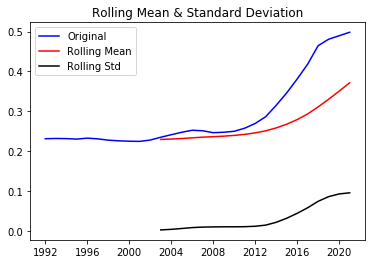

ADF Statistic: 1.6888240190798178
p-value: 0.9981010298419788
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111


In [6]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(agridata)

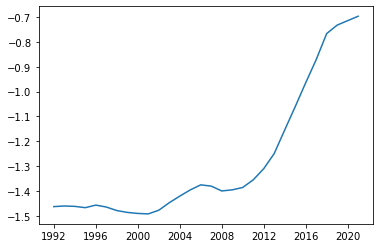

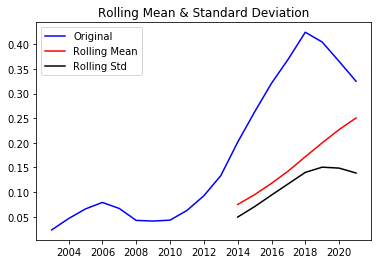

ADF Statistic: -0.9962626436236547
p-value: 0.754624974110123
Critical Values:
	1%: -4.01203360058309
	5%: -3.1041838775510207
	10%: -2.6909873469387753


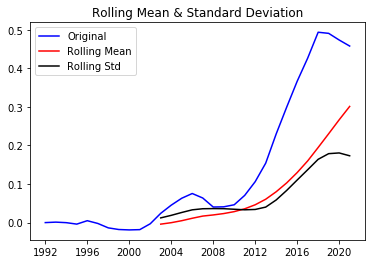

ADF Statistic: -1.7857625906444432
p-value: 0.38755272928698437
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


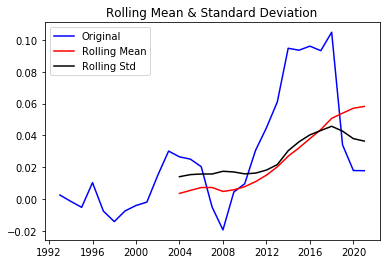

ADF Statistic: -1.4248725921104404
p-value: 0.5702955205088781
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


In [7]:
df_log = np.log(agridata)
plt.plot(df_log)
plt.show()

rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [8]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(agridata)

#define function for kpss test
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(agridata)

Results of Dickey-Fuller Test:
Test Statistic                  1.688824
p-value                         0.998101
#Lags Used                      5.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64
Results of KPSS Test:
Test Statistic           0.386723
p-value                  0.082878
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


## ARIMA

In [26]:
rmse_all = []
MAPE_all = []
MAE_all = []
all_metrics = []
for i in range(3):    
    rmseavg=0
    MAPE=0
    MAE=0
    predict_data = []
    
    for k in range(0,187):
        try:
            if i == 0:
                data = df_agriculture.loc[k, df_agriculture.columns != 'Country Name'].to_list()
            elif i == 1:
                data = df_service.loc[k, df_service.columns != 'Country Name'].to_list()
            else:
                data = df_industry.loc[k, df_industry.columns != 'Country Name'].to_list()

            index= pd.date_range(start='1991', end='2021', freq='A')
            factor_data = pd.Series(data, index)

            ##--Evaluation--##
            train = factor_data[:25]
            test = factor_data[25:]
            arima_model =  auto_arima(train,start_p=0, start_q=0, max_p=5, D= 0,
                                  max_d=5, max_q=5, start_P=0, start_Q=0, 
                                  max_P=5, max_D=5, max_Q=5, m=1,
                                  error_action='warn',trace = False,
                                  supress_warnings=True,stepwise = True)
            predictions = arima_model.fit_predict(train,n_periods = 5)
            rmseavg+= ( round(np.sqrt( ((predictions - test) ** 2).mean() ), 2) )
            MAPE = MAPE+ ( np.sum( np.abs(np.subtract(test,predictions)) ) / np.sum(test) )
            MAE = MAE+ mean_absolute_error(test,predictions)

            ##--Predictions--##
            arima_model_full =  auto_arima(factor_data,start_p=0, start_q=0, max_p=5, D= 0,
                                  max_d=5, max_q=5, start_P=0, start_Q=0, 
                                  max_P=5, max_D=5, max_Q=5, m=1,
                                  error_action='warn',trace = False,
                                  supress_warnings=True,stepwise = True)
            predictions_full = arima_model.fit_predict(factor_data,n_periods = 5)
            predict_data.append(predictions_full)
        except:
            #print("Error in : ", i, "th factor : ",k)
            predict_data.append([0,0,0,0,0])

        
    predict_data = np.array(predict_data).T
    if i == 0:
        print("---Agriculture Factor---")
        df_agriculture_predict['2021_arima']= predict_data[0]
        df_agriculture_predict['2022_arima']= predict_data[1]
        df_agriculture_predict['2023_arima']= predict_data[2]
        df_agriculture_predict['2024_arima']= predict_data[3]
        df_agriculture_predict['2025_arima']= predict_data[4]
    elif i==1:
        print("---Service Factor---")
        df_service_predict['2021_arima']= predict_data[0]
        df_service_predict['2022_arima']= predict_data[1]
        df_service_predict['2023_arima']= predict_data[2]
        df_service_predict['2024_arima']= predict_data[3]
        df_service_predict['2025_arima']= predict_data[4]
    else:
        print("---Industry Factor---")
        df_industry_predict['2021_arima']= predict_data[0]
        df_industry_predict['2022_arima']= predict_data[1]
        df_industry_predict['2023_arima']= predict_data[2]
        df_industry_predict['2024_arima']= predict_data[3]
        df_industry_predict['2025_arima']= predict_data[4]
    rmse_all.append(rmseavg/187)
    MAPE_all.append(MAPE/187)
    MAE_all.append(MAE/187)
    print('RMSE: '+ str(rmseavg/187))
    print('MAPE: '+ str(MAPE/187))
    print('MAE: '+ str(MAE/187))
all_metrics.append(rmse_all) 
all_metrics.append(MAPE_all) 
all_metrics.append(MAE_all) 
print(rmse_all, MAPE_all, MAE_all)

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

---Agriculture Factor---
RMSE: 0.03085561497326198
MAPE: 0.07921984394094612
MAE: 0.028714743005662


/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

---Service Factor---
RMSE: 0.02983957219251331
MAPE: 0.037546305906315025
MAE: 0.026935971793900792


/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood opti

---Industry Factor---
RMSE: 0.020855614973261986
MAPE: 0.06833895163432432
MAE: 0.01903167302514492
[0.03085561497326198, 0.02983957219251331, 0.020855614973261986] [0.07921984394094612, 0.037546305906315025, 0.06833895163432432] [0.028714743005662, 0.026935971793900792, 0.01903167302514492]


/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Holt Linear Trend Model

## Parameter Optimization and Model Selection

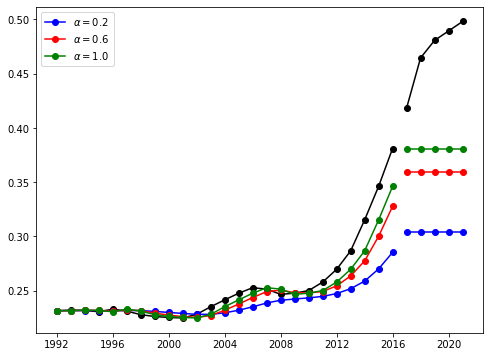

In [27]:
train = agridata[:25]
test = agridata[25:]
fit1 = SimpleExpSmoothing(train).fit(smoothing_level=0.2,optimized=False)
fcast1 = fit1.forecast(5).rename(r'$\alpha=0.2$')
fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6,optimized=False)
fcast2 = fit2.forecast(5).rename(r'$\alpha=0.6$')
fit3 = SimpleExpSmoothing(train).fit()
fcast3 = fit3.forecast(5).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])

plt.figure(figsize=(8, 6))
plt.plot(train, marker='o', color='black')
plt.plot(test, marker='o', color='black')
plt.plot(fit1.fittedvalues, marker='o', color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, marker='o', color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
plt.plot(fit3.fittedvalues, marker='o', color='green')
line3, = plt.plot(fcast3, marker='o', color='green')
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

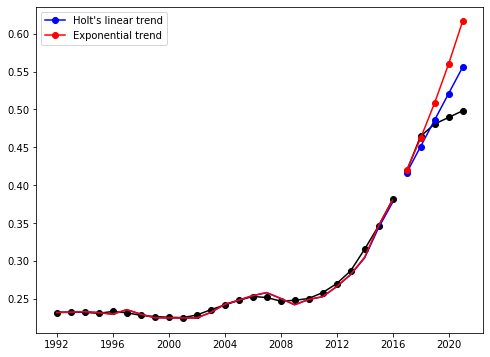

In [28]:
# fit1 = Holt(train).fit(smoothing_trend=0.3)
# fcast1 = fit1.forecast(5).rename("Holt's linear trend")
# fit2 = Holt(train, exponential=True).fit(smoothing_trend=0.3)
# fcast2 = fit2.forecast(5).rename("Exponential trend")
# fit3 = Holt(train, damped_trend=True).fit(smoothing_trend=0.3)
# fcast3 = fit3.forecast(5).rename("Additive damped trend")

fit1 = Holt(train).fit()
fcast1 = fit1.forecast(5).rename("Holt's linear trend")
fit2 = Holt(train, exponential=True).fit()
fcast2 = fit2.forecast(5).rename("Exponential trend")
# fit3 = Holt(train, damped_trend=True).fit()
# fcast3 = fit3.forecast(5).rename("Additive damped trend")
plt.figure(figsize=(8, 6))
plt.plot(train, marker='o', color='black')
plt.plot(test, marker='o', color='black')
plt.plot(fit1.fittedvalues, color='blue')
line1, = plt.plot(fcast1, marker='o', color='blue')
plt.plot(fit2.fittedvalues, color='red')
line2, = plt.plot(fcast2, marker='o', color='red')
# plt.plot(fit3.fittedvalues, color='green')
# line3, = plt.plot(fcast3, marker='o', color='green')
# plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])
plt.legend([line1, line2], [fcast1.name, fcast2.name])

## Holt Model

In [30]:
rmse_all = []
MAPE_all = []
MAE_all = []
for i in range(3):    
    rmseavg=0
    MAPE=0
    MAE=0
    predict_data = []
    
    for k in range(0,187):
        if i == 0:
            data = df_agriculture.loc[k, df_agriculture.columns != 'Country Name'].to_list()
        elif i == 1:
            data = df_service.loc[k, df_service.columns != 'Country Name'].to_list()
        else:
            data = df_industry.loc[k, df_industry.columns != 'Country Name'].to_list()
        index= pd.date_range(start='1991', end='2021', freq='A')
        factor_data = pd.Series(data, index)

        ##--Evaluation--##
        train = factor_data[:25]
        test = factor_data[25:]
        fit_eval = Holt(train).fit()
        fcast_eval = fit_eval.forecast(5).rename(r'Holts Linear Trend Model \alpha=%s$'%fit_eval.model.params['smoothing_level'])
        rmseavg+= ( round(np.sqrt( ((fcast_eval - test) ** 2).mean() ), 2) )
        MAPE = MAPE+ ( np.sum( np.abs(np.subtract(test,fcast_eval)) ) / np.sum(test) )
        MAE = MAE+ mean_absolute_error(test,fcast_eval)

        ##--Predictions--##
        fit = Holt(factor_data).fit()
        fcast = fit.forecast(5).rename(r'Holts Linear Trend Model \alpha=%s$'%fit.model.params['smoothing_level'])
        predict_data.append(list(fcast))

        
    predict_data = np.array(predict_data).T
    if i == 0:
        print("---Agriculture Factor---")
        df_agriculture_predict['2021_holt']= predict_data[0]
        df_agriculture_predict['2022_holt']= predict_data[1]
        df_agriculture_predict['2023_holt']= predict_data[2]
        df_agriculture_predict['2024_holt']= predict_data[3]
        df_agriculture_predict['2025_holt']= predict_data[4]
    elif i==1:
        print("---Service Factor---")
        df_service_predict['2021_holt']= predict_data[0]
        df_service_predict['2022_holt']= predict_data[1]
        df_service_predict['2023_holt']= predict_data[2]
        df_service_predict['2024_holt']= predict_data[3]
        df_service_predict['2025_holt']= predict_data[4]
    else:
        print("---Industry Factor---")
        df_industry_predict['2021_holt']= predict_data[0]
        df_industry_predict['2022_holt']= predict_data[1]
        df_industry_predict['2023_holt']= predict_data[2]
        df_industry_predict['2024_holt']= predict_data[3]
        df_industry_predict['2025_holt']= predict_data[4]
    rmse_all.append(rmseavg/187)
    MAPE_all.append(MAPE/187)
    MAE_all.append(MAE/187)
    print('RMSE: '+ str(rmseavg/187))
    print('MAPE: '+ str(MAPE/187))
    print('MAE: '+ str(MAE/187))
all_metrics.append(rmse_all) 
all_metrics.append(MAPE_all) 
all_metrics.append(MAE_all) 
# print(rmse_all, MAPE_all, MAE_all)

/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinter

---Agriculture Factor---
RMSE: 0.034224598930481215
MAPE: 0.09440732408302739
MAE: 0.03145407664243865


/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinter

---Service Factor---
RMSE: 0.028983957219251257
MAPE: 0.033134708836499174
MAE: 0.026275250823702953


/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/amatullah/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinter

---Industry Factor---
RMSE: 0.022352941176470534
MAPE: 0.06429125108721691
MAE: 0.020581566900625962


In [31]:
all_metrics

[[0.03085561497326198, 0.02983957219251331, 0.020855614973261986],
 [0.07921984394094612, 0.037546305906315025, 0.06833895163432432],
 [0.028714743005662, 0.026935971793900792, 0.01903167302514492],
 [0.034224598930481215, 0.028983957219251257, 0.022352941176470534],
 [0.09440732408302739, 0.033134708836499174, 0.06429125108721691],
 [0.03145407664243865, 0.026275250823702953, 0.020581566900625962]]

# Predicting GEPI

In [32]:
df_GenderEmploymentIndex_predict['2021_arima']= (df_agriculture_predict['2021_arima']
                                                 + df_service_predict['2021_arima']
                                                +  df_industry_predict['2021_arima'])/3
df_GenderEmploymentIndex_predict['2022_arima']= (df_agriculture_predict['2022_arima']
                                                 + df_service_predict['2022_arima']
                                                +  df_industry_predict['2022_arima'])/3
df_GenderEmploymentIndex_predict['2023_arima']= (df_agriculture_predict['2023_arima']
                                                 + df_service_predict['2023_arima']
                                                +  df_industry_predict['2023_arima'])/3
df_GenderEmploymentIndex_predict['2024_arima']= (df_agriculture_predict['2024_arima']
                                                 + df_service_predict['2024_arima']
                                                +  df_industry_predict['2024_arima'])/3
df_GenderEmploymentIndex_predict['2025_arima']= (df_agriculture_predict['2025_arima']
                                                 + df_service_predict['2025_arima']
                                                +  df_industry_predict['2025_arima'])/3

df_GenderEmploymentIndex_predict['2021_holt']= (df_agriculture_predict['2021_holt']+ df_service_predict['2021_holt']
                                                +  df_industry_predict['2021_holt'])/3
df_GenderEmploymentIndex_predict['2022_holt']= (df_agriculture_predict['2022_holt']+ df_service_predict['2022_holt']
                                                +  df_industry_predict['2022_holt'])/3
df_GenderEmploymentIndex_predict['2023_holt']=(df_agriculture_predict['2023_holt']+ df_service_predict['2023_holt']
                                                +  df_industry_predict['2023_holt'])/3
df_GenderEmploymentIndex_predict['2024_holt']= (df_agriculture_predict['2024_holt']+ df_service_predict['2024_holt']
                                                +  df_industry_predict['2024_holt'])/3
df_GenderEmploymentIndex_predict['2025_holt']= (df_agriculture_predict['2025_holt']+ df_service_predict['2025_holt']
                                                +  df_industry_predict['2025_holt'])/3

df_GenderEmploymentIndex_predict.head(5)

,Country Name,Country Code,IncomeGroup,Region,1991,1992,1993,1994,1995,1996,...,2021_arima,2022_arima,2023_arima,2024_arima,2025_arima,2021_holt,2022_holt,2023_holt,2024_holt,2025_holt
0,Afghanistan,AFG,Low income,South Asia,0.175509,0.175674,0.175586,0.174958,0.173189,0.171336,...,0.330425,0.332750,0.333929,0.334106,0.333443,0.331750,0.336661,0.341573,0.346484,0.351395
1,Angola,AGO,Lower middle income,Sub-Saharan Africa,0.838068,0.834380,0.828815,0.827345,0.831461,0.835798,...,0.773558,0.773360,0.772985,0.772525,0.772023,0.773777,0.774815,0.775853,0.776891,0.777929
2,Albania,ALB,Upper middle income,Europe & Central Asia,0.664991,0.664567,0.653707,0.649168,0.641363,0.633962,...,0.713835,0.717064,0.719704,0.721842,0.723552,0.722104,0.729815,0.737526,0.745237,0.752948
3,United Arab Emirates,ARE,High income,Middle East & North Africa,0.208662,0.213521,0.219037,0.219931,0.220510,0.224616,...,0.314712,0.314207,0.313783,0.313324,0.312911,0.314751,0.314326,0.313901,0.313476,0.313051
4,Argentina,ARG,Upper middle income,Latin America & Caribbean,0.432832,0.524447,0.468807,0.446651,0.438933,0.395072,...,0.445482,0.431450,0.431223,0.430938,0.430630,0.461983,0.470091,0.478199,0.486307,0.494415


## Calculating 5 year averages

In [ ]:
df_GenderEmploymentIndex_predict['pre5yearaverage'] = \
    df_GenderEmploymentIndex_predict[['2016','2017','2018','2019','2020']].mean(axis=1)

df_GenderEmploymentIndex_predict['post5yearaverage_arima'] = \
    df_GenderEmploymentIndex_predict[['2021_arima','2022_arima','2023_arima','2024_arima','2025_arima']].mean(axis=1)

df_GenderEmploymentIndex_predict['post5yearaverage_holt'] = \
    df_GenderEmploymentIndex_predict[['2021_holt','2022_holt','2023_holt','2024_holt','2025_holt']].mean(axis=1)

df_GenderEmploymentIndex_predict.to_csv (r'forecast_values_ARIMA_Holt.csv', index = None, header=True) 

## Evaluation using SES Model

In [77]:
df1 = pd.read_csv('forecast_values_SES_DES.csv')
df_GenderEmploymentIndex_predict['SES_diff'] = \
    df1['pre5yearaverage'] - \
    df1['post5yearaverage-SES']

df_neg = df_GenderEmploymentIndex_predict.loc[(df_GenderEmploymentIndex_predict['SES_diff']<0)]
df_pos = df_GenderEmploymentIndex_predict.loc[(df_GenderEmploymentIndex_predict['SES_diff']>0)]

# print(len(df_neg), len(df_pos), len(df_negpos), len(df_posneg))
print(len(df_neg), len(df_pos))

84 103


### Regional & Income Group Analysis

In [171]:
region_incGEPI = df_neg.groupby(df_neg['Region']).size().to_list()
region_incGEPI.insert(4,0)
region_decGEPI = df_pos.groupby(df_pos['Region']).size().to_list()
regions = list(df_pos.groupby(df_pos['Region']).groups.keys())

income_incGEPI = df_neg.groupby(df_neg['IncomeGroup']).size().to_list()
income_decGEPI = df_pos.groupby(df_pos['IncomeGroup']).size().to_list()
incgroups = list(df_pos.groupby(df_pos['IncomeGroup']).groups.keys())
# df_reg = pd.DataFrame(zip(regions*3, ["Increasing GEPI"]*7+["Decreasing GEPI"]*7, region_incGEPI+region_decGEPI), columns=["Region", "Kind", "Count"])
# plt.figure(figsize=(15, 6))
# sns.barplot(x="Region", hue="Kind", y="Count", data=df_reg)
df_reg = pd.DataFrame()
df_reg['Regions'] = regions
df_reg['Increasing GEPI'] = region_incGEPI
df_reg['Decreasing GEPI'] = region_decGEPI
# df_reg.plot.bar(x="Regions", rot = 10, figsize = (10,5) )

df_inc = pd.DataFrame()
df_inc['Income Groups'] = incgroups
df_inc['Increasing GEPI'] = income_incGEPI
df_inc['Decreasing GEPI'] = income_decGEPI
# df_inc.plot.bar(x="Income Groups", rot = 10, figsize = (10,5) )


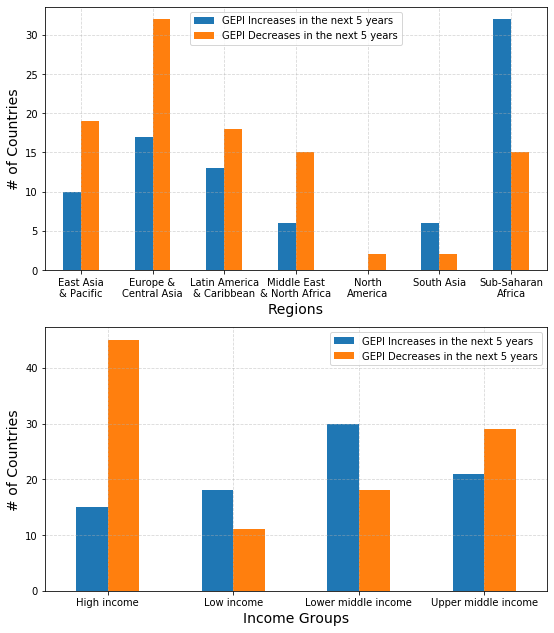

In [172]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (15,10))
fig.delaxes(axes[0][1])    
fig.delaxes(axes[1][1]) 

tick = ['East Asia\n& Pacific', 'Europe &\nCentral Asia','Latin America\n& Caribbean',
        'Middle East\n& North Africa','North\nAmerica','South Asia','Sub-Saharan\nAfrica']
# ax = df.A.plot(xticks=df.index, rot=90)
# ax.set_xticklabels(df.C)

yr = [0]

for i in range(2):
    if(i == 0) :
        ax = df_reg.plot.bar(x="Regions", rot = 0, ax=axes[0,0], xticks = df_reg.index )
        ax.set_xlabel("Regions", fontsize = 14)
        ax.set_xticklabels(tick)
        ax.legend(['GEPI Increases in the next 5 years', 
                   'GEPI Decreases in the next 5 years'])
#         for i in ax.patches:
#             if(i.get_height() != 0):
#                 ax.text(i.get_xy()[0], i.get_height(), str(i.get_height()), 
#                         fontsize=10, fontweight = 'bold')
    elif(i == 1) :
        ax = df_inc.plot.bar(x="Income Groups", rot = 0, ax=axes[1,0] )
        ax.set_xlabel("Income Groups", fontsize = 14)
        ax.legend(['GEPI Increases in the next 5 years', 
                   'GEPI Decreases in the next 5 years'])
#         for i in ax.patches:
#             if(i.get_height() != 0):
#                 ax.text(i.get_xy()[0]+0.05, i.get_height()-0.38, str(i.get_height()), 
#                         fontsize=10, fontweight = 'bold')
    ax.set_ylabel("# of Countries", fontsize = 14)
    ax.grid(which='both', axis='both', linestyle = '--', alpha = 0.5)

# fig.suptitle('Gender Disparity in Employment',x = 0.3, y = 0.95, fontweight ="bold", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.92])

In [86]:
print("---- Increasing GEPI ----")
print(df_neg.groupby(df_neg['Region']).size())
print("\n---- Decreasing GEPI ----")
print(df_pos.groupby(df_pos['Region']).size())
print("\n---- Leading Regions (Decreasing - Increasing) ----")
print(df_pos.groupby(df_pos['Region']).size()-df_neg.groupby(df_neg['Region']).size())

---- Increasing GEPI ----
Region
East Asia & Pacific           10
Europe & Central Asia         17
Latin America & Caribbean     13
Middle East & North Africa     6
South Asia                     6
Sub-Saharan Africa            32
dtype: int64

---- Decreasing GEPI ----
Region
East Asia & Pacific           19
Europe & Central Asia         32
Latin America & Caribbean     18
Middle East & North Africa    15
North America                  2
South Asia                     2
Sub-Saharan Africa            15
dtype: int64

---- Leading Regions (Decreasing - Increasing) ----
Region
East Asia & Pacific            9.0
Europe & Central Asia         15.0
Latin America & Caribbean      5.0
Middle East & North Africa     9.0
North America                  NaN
South Asia                    -4.0
Sub-Saharan Africa           -17.0
dtype: float64


In [87]:
print("---- Increasing GEPI ----")
print(df_neg.groupby(df_neg['IncomeGroup']).size())
print("\n---- Decreasing GEPI ----")
print(df_pos.groupby(df_pos['IncomeGroup']).size())
print("\n---- Leading Regions (Decreasing - Increasing) ----")
print(df_pos.groupby(df_pos['IncomeGroup']).size()-df_neg.groupby(df_neg['IncomeGroup']).size())

---- Increasing GEPI ----
IncomeGroup
High income            15
Low income             18
Lower middle income    30
Upper middle income    21
dtype: int64

---- Decreasing GEPI ----
IncomeGroup
High income            45
Low income             11
Lower middle income    18
Upper middle income    29
dtype: int64

---- Leading Regions (Decreasing - Increasing) ----
IncomeGroup
High income            30
Low income             -7
Lower middle income   -12
Upper middle income     8
dtype: int64


## Plotting GEPI Heatmaps

### From 2016 to 2020

In [78]:
fig = go.Figure(data=go.Choropleth(
    locations = df2['Country Code'],
    z = df2['pre5yearaverage'],
    text = df2['Country Name'],
    colorscale = 'Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'GEPI',
))

fig.update_layout(
    title_text='Average GEPI of countries from 2016 to 2020',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
    
)

fig.show()

### ARIMA Model 2021-2025 GEPI Avg

In [34]:
fig = go.Figure(data=go.Choropleth(
    locations = df2['Country Code'],
    z = df2['post5yearaverage_arima'],
    text = df2['Country Name'],
    colorscale = 'Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'GEPI',
))

fig.update_layout(
    title_text='Average GEPI of countries from 2021 to 2025 using ARIMA Model',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
    
)

fig.show()

### Holt's Model 2021-2025 GEPI Avg

In [35]:
fig = go.Figure(data=go.Choropleth(
    locations = df2['Country Code'],
    z = df2['post5yearaverage_holt'],
    text = df2['Country Name'],
    colorscale = 'Viridis',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '',
    colorbar_title = 'GEPI',
))

fig.update_layout(
    title_text='Average GEPI of countries from 2021 to 2025 using Holt Linear Trend Model',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
    
)

fig.show()